# Лабораторная работа № 3

## 1. Определение бизнес-целей для набора данных

### Бизнес-цель 1

Определить факторы, влияющие на успеваемость студентов в экзаменах, чтобы разработать программы поддержки для улучшения общих результатов (например, выявить студентов с риском низких баллов).

### Бизнес-цель 2

Оценить влияние подготовки к тестам и социально-экономических факторов на производительность, чтобы оптимизировать распределение ресурсов в образовательных учреждениях (например, решить, стоит ли расширять курсы подготовки).

## 2. Формулировка технических целей проекта

### Бизнес-цель 1

Построить модель регрессии для предсказания среднего балла по экзаменам (математика, чтение, письмо) на основе демографических и подготовительных признаков.

### Бизнес-цель 2

Построить модель классификации для предсказания, будет ли студент иметь высокую производительность (средний балл > 70), чтобы анализировать ключевые факторы.

## 3. Подготовка и сбор данных

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import time
import featuretools as ft
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/students_performance.csv')

print(df.head())
print(df.info())
print(df.describe())

print(df.isnull().sum())

df['average_score'] = (df['math score'] + df['reading score'] + df['writing score']) / 3

df['high_performance'] = np.where(df['average_score'] > 70, 1, 0)

print(df['high_performance'].value_counts(normalize=True))

   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtyp

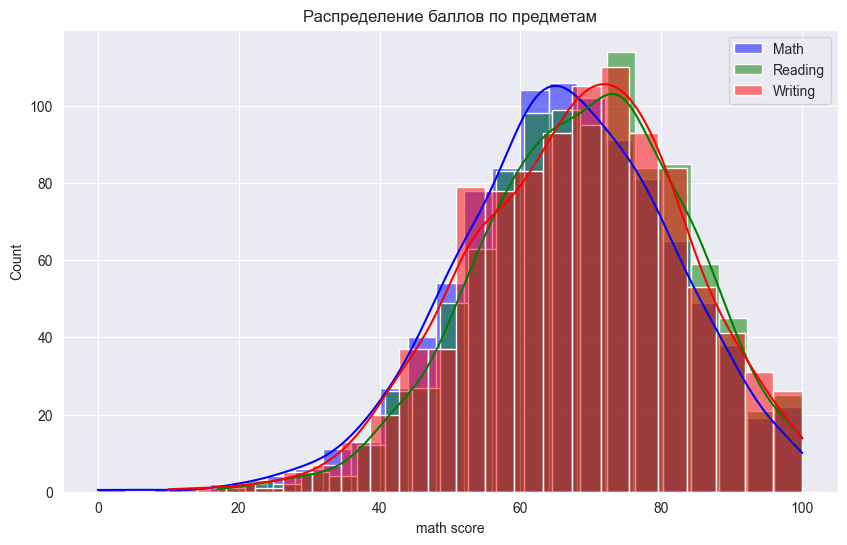

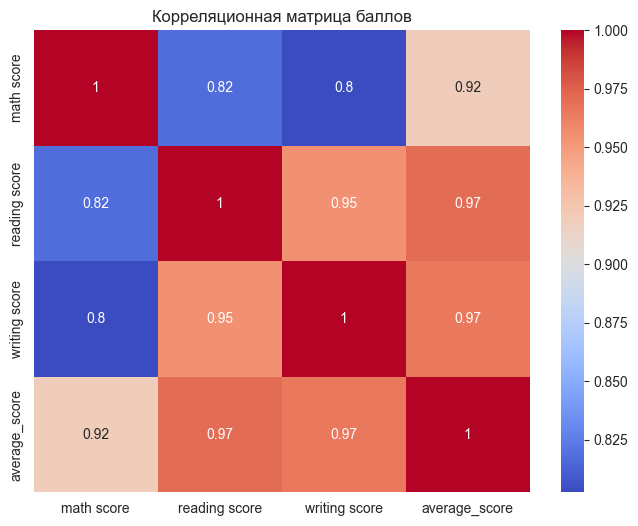

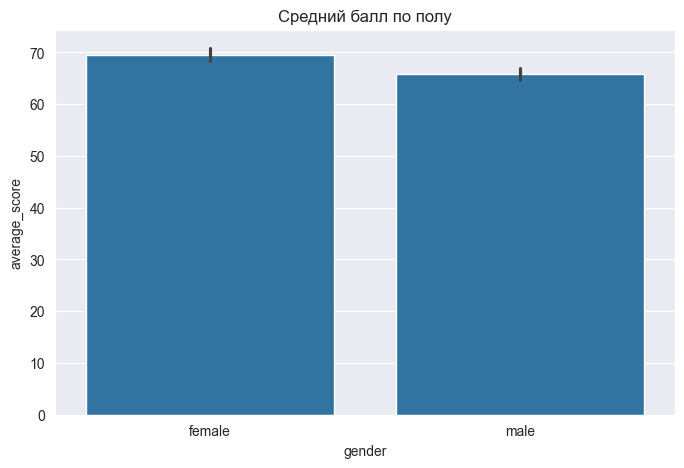

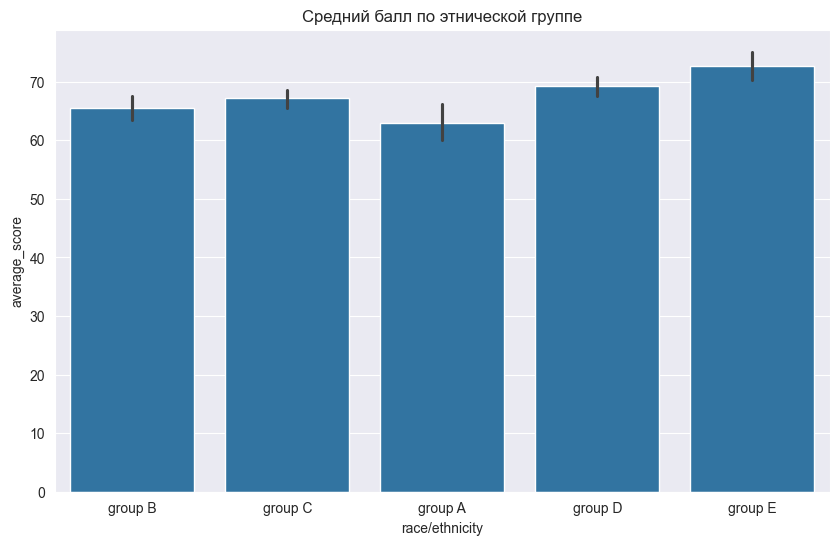

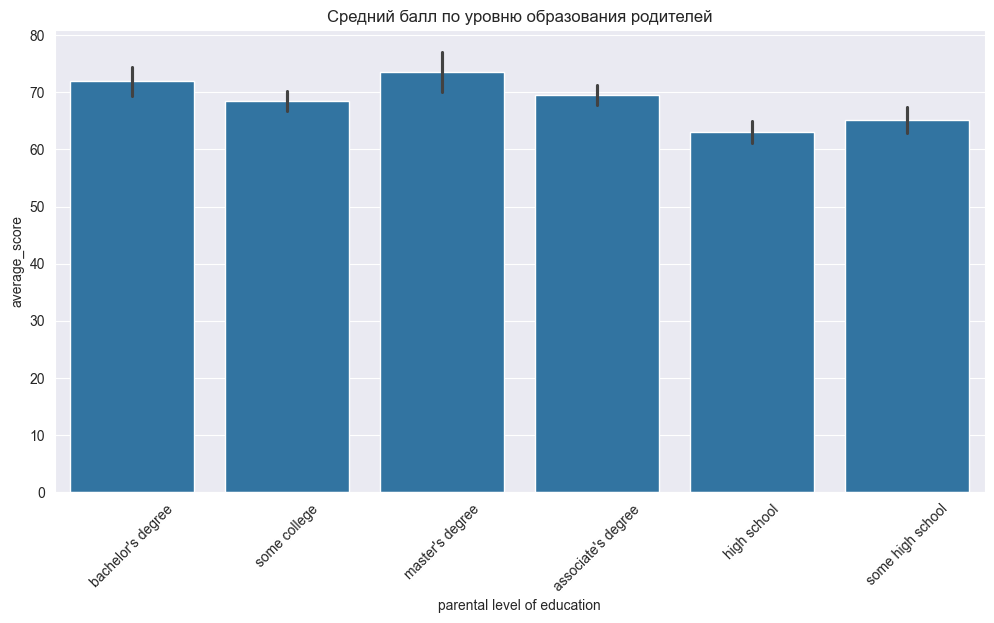

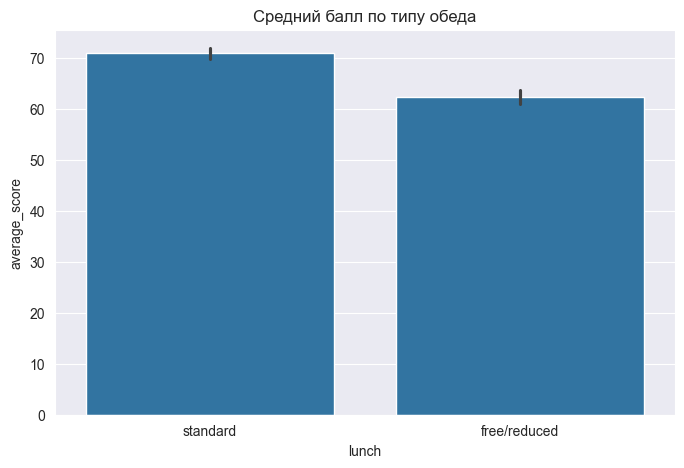

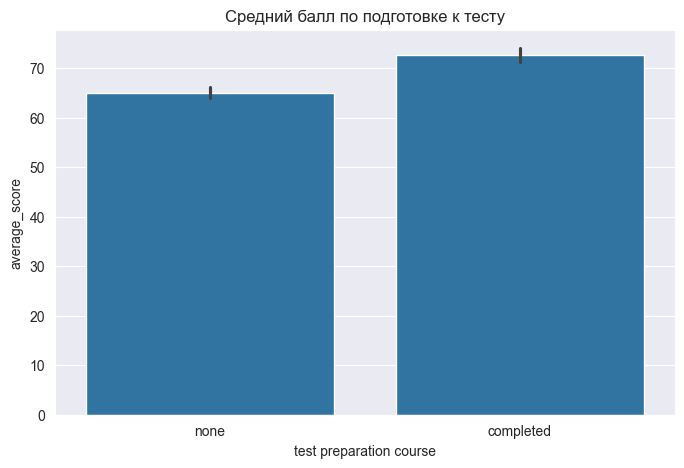

In [3]:
# Распределение баллов по предметам
plt.figure(figsize=(10, 6))
sns.histplot(df['math score'], kde=True, color='blue', label='Math')
sns.histplot(df['reading score'], kde=True, color='green', label='Reading')
sns.histplot(df['writing score'], kde=True, color='red', label='Writing')
plt.title('Распределение баллов по предметам')
plt.legend()
plt.show()

# Корреляционная матрица
plt.figure(figsize=(8, 6))
corr = df[['math score', 'reading score', 'writing score', 'average_score']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица баллов')
plt.show()

# Барчарт среднего балла по полу
plt.figure(figsize=(8, 5))
sns.barplot(x='gender', y='average_score', data=df)
plt.title('Средний балл по полу')
plt.show()

# Барчарт по этнической группе
plt.figure(figsize=(10, 6))
sns.barplot(x='race/ethnicity', y='average_score', data=df)
plt.title('Средний балл по этнической группе')
plt.show()

# Барчарт по уровню образования родителей
plt.figure(figsize=(12, 6))
sns.barplot(x='parental level of education', y='average_score', data=df)
plt.title('Средний балл по уровню образования родителей')
plt.xticks(rotation=45)
plt.show()

# Барчарт по типу обеда (социально-экономический фактор)
plt.figure(figsize=(8, 5))
sns.barplot(x='lunch', y='average_score', data=df)
plt.title('Средний балл по типу обеда')
plt.show()

# Барчарт по подготовке к тесту
plt.figure(figsize=(8, 5))
sns.barplot(x='test preparation course', y='average_score', data=df)
plt.title('Средний балл по подготовке к тесту')
plt.show()

## 4. Разбиение данных на обучающую, контрольную и тестовую выборки

In [5]:
features = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
X = df[features]
y_reg = df['average_score']
y_clf = df['high_performance']

# 70% train, 15% val, 15% test
X_train, X_temp, y_reg_train, y_reg_temp = train_test_split(X, y_reg, test_size=0.3, random_state=42)
X_val, X_test, y_reg_val, y_reg_test = train_test_split(X_temp, y_reg_temp, test_size=0.5, random_state=42)

_, _, y_clf_train, y_clf_temp = train_test_split(X, y_clf, test_size=0.3, random_state=42)
y_clf_val, y_clf_test = train_test_split(y_clf_temp, test_size=0.5, random_state=42)

## 5. Анализ сбалансированности и аугментация данных

In [6]:
print('Train class balance:', y_clf_train.value_counts(normalize=True))

Train class balance: high_performance
0    0.542857
1    0.457143
Name: proportion, dtype: float64


## 6-7. Конструирование признаков для решения бизнес-задач

### Ручное конструирование

In [10]:
# One-hot encoding
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)


# Ручной синтез признаков
def add_manual_features(df):
    high_edu = ["bachelor's degree", "master's degree", "associate's degree"]
    df['privileged'] = np.where((df['lunch'] == 'standard') & (df['parental level of education'].isin(high_edu)), 1, 0)
    df['prepared'] = np.where(df['test preparation course'] == 'completed', 1, 0)
    return df


X_train_manual = add_manual_features(X_train.copy())
X_val_manual = add_manual_features(X_val.copy())
X_test_manual = add_manual_features(X_test.copy())

X_train_manual_encoded = np.hstack((encoder.fit_transform(X_train_manual.drop(['privileged', 'prepared'], axis=1)),
                                    X_train_manual[['privileged', 'prepared']].values))

scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train_encoded)
X_val_std = scaler_std.transform(X_val_encoded)
X_test_std = scaler_std.transform(X_test_encoded)

scaler_norm = MinMaxScaler()
X_train_norm = scaler_norm.fit_transform(X_train_encoded)
X_val_norm = scaler_norm.transform(X_val_encoded)
X_test_norm = scaler_norm.transform(X_test_encoded)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

## 8. Автоматизированное конструирование признаков с помощью Featuretools

In [12]:
# Создаем entity set
es = ft.EntitySet(id='students')
es = es.add_dataframe(dataframe_name='data', dataframe=df[features + ['average_score']], index='index')

# Автоматическое создание признаков
feature_matrix, feature_defs = ft.dfs(entityset=es, target_dataframe_name='data',
                                      trans_primitives=['add_numeric', 'multiply_numeric'], max_depth=1)

# Feature matrix для train/val/test (нужно индексировать соответственно)
# Для простоты, используем feature_matrix и разбиваем заново.
X_ft = feature_matrix.drop('average_score', axis=1)  # Если добавлены
# Затем split как выше.

/home/ivan/Projects/AIM-PIbd-31-Gutorov-I-A-github/.venv/lib/python3.13/site-packages/featuretools/entityset/entityset.py:1733: UserWarning: index index not found in dataframe, creating new integer column
  warnings.warn(
/home/ivan/Projects/AIM-PIbd-31-Gutorov-I-A-github/.venv/lib/python3.13/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/home/ivan/Projects/AIM-PIbd-31-Gutorov-I-A-github/.venv/lib/python3.13/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/home/ivan/Projects/AIM-PIbd-31-Gutorov-I-A-github/.venv/lib/python3.13/site-packages/woodwork/type_sys/utils.py:33: UserWarning: Could not 

## 9. Оценка качества наборов признаков

In [154]:
# Подготовка данных
X_manual = pd.get_dummies(df_feat.drop(['math_score', 'math_gain', 'expected_gain', 'student_id'], axis=1),
                          drop_first=True)
X_ft = feature_matrix.drop(['math_score', 'math_gain', 'expected_gain'], axis=1, errors='ignore')

# Убедимся, что нет NaN
X_manual = X_manual.fillna(0)
X_ft = X_ft.fillna(0)


# Обучение и оценка
def evaluate_features(X, name):
    start = time.time()
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_res, y_risk_train_res)
    pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_risk_val, pred)
    duration = time.time() - start
    corr = X.corr().abs().unstack().mean()
    print(f"{name}: AUC = {auc:.3f}, Время = {duration:.2f}с, Средняя корреляция = {corr:.3f}")


evaluate_features(X_manual.loc[X_val.index], "Ручные признаки")
evaluate_features(X_ft.loc[X_val.index], "Featuretools")

TypeError: Cannot setitem on a Categorical with a new category (0), set the categories first